In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from src.helpers import confidence_interval, what_informality
import pickle
from sklearn import preprocessing
import random
import json

In [2]:
style.use('seaborn-white')

### 1 load general the parameters

In [3]:
with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['data_output'] = 'csv_light'

In [4]:
#ADDED THIS
parameters['number_of_agents'] = 100000

initial_agents = max(round((310 / (3740026 / parameters['number_of_agents']) * 100/14)), 20) # 310 cases / (population / agent) * 1 / 14% detected cases
initial_agents

59

In [5]:
# added this as well. 
parameters['lockdown_days'] = [x for x in range(0, parameters['time'])]
parameters['total_initial_infections'] = [x for x in range(initial_agents)]
#parameters['probability_transmission'] = 0.1

In [6]:
# parameters['informality_dummy'] = 1.0
# parameters['lockdown_days'] = [x for x in range(20, parameters['time'])]
# parameters['probability_transmission'] = 0.1
# parameters['total_initial_infections'] = [x for x in range(18)]

### 2 load neighbourhood data

In [7]:
with open('parameters/district_data_100k.json') as json_file:
    neighbourhood_data = json.load(json_file)

## TRY THE SCENARIOS HERE

In [8]:
data1 = open('seed_22_forjoeri.pkl', "rb")
list_of_objects1 = pickle.load(data1)
environment_base = list_of_objects1[0]

data2 = open('seed_22_forjoeri.pkl', "rb")
list_of_objects2 = pickle.load(data2)
environment_formal = list_of_objects2[0]

data3 = open('seed_22_forjoeri.pkl', "rb")
list_of_objects3 = pickle.load(data3)
environment_informal = list_of_objects3[0]

scenarios = ['baseline', 'formal_lockdown', 'informal_lockdown']
environments = [environment_base, environment_formal, environment_informal]

In [9]:
for idx, env in enumerate(environments):
    # correct time
    environments[idx].parameters['time'] = parameters['time']

    # make scenario 
    if idx == 1:
        print('oohh yeah')
        environments[idx].parameters["informality_dummy"] = 0.0
    elif idx == 2:
        environments[idx].parameters["informality_dummy"] = 1.0
    
    # correct informality
    if environments[idx].parameters["informality_dummy"] == 1.0:
        for agent in environments[idx].agents:
            agent.informality = what_informality(agent.district, neighbourhood_data) * parameters["informality_dummy"]

    environments[idx].parameters['probability_transmission'] = parameters['probability_transmission']#!!!!###!!!###
    environments[idx].parameters['number_of_agents'] = 100000 #!!!!###!!!###
    environments[idx].parameters['data_output']= parameters['data_output']#!!!!###!!!###
    environments[idx].parameters["total_initial_infections"]= parameters["total_initial_infections"]
    environments[idx].parameters["lockdown_days"] = parameters["lockdown_days"] 
    environments[idx].parameters["health_system_capacity"] = parameters["health_system_capacity"]
    
    # ADD NEW PARAMETER
    environments[idx].parameters["perc_infections_detects"] = 1.0#parameters['perc_infections_detects']
    # ADD NEWLY DETECTED CASES
    environments[idx].newly_detected_cases = [0 for x in range(parameters['time'])]
    
    # CHANGE POLICY PARAMETERS
    env.parameters["physical_distancing_multiplier"] = 0.91# 0.51
    env.parameters["visiting_recurring_contacts_multiplier"] = 0.75 #0.5387393162393163
    env.parameters["likelihood_awareness"] = 0.54 # 0.54
    env.parameters["gathering_max_contacts"] = 24# 12

oohh yeah


In [10]:
data_folder = 'measurement/baseline_100k/'
seed = 22

In [11]:
for env, sc in zip(environments, scenarios):
    if sc == 'baseline':
        env.parameters["lockdown_days"] = [0 for x in parameters["lockdown_days"]]
    if sc == 'formal_lockdown':
        env.parameters['informality_dummy'] = 0.0
    
    if sc == 'informal_lockdown':
        env.parameters['informality_dummy'] = 1.0
    
    if env.parameters['informality_dummy'] == 1.0:
        for agent in env.agents:
            agent.informality = what_informality(agent.district, neighbourhood_data) * parameters["informality_dummy"]
        
    env = runner(env, 0, data_folder=data_folder, data_output=env.parameters['data_output'])
    
    if parameters["data_output"] == 'csv_light':
        pd.DataFrame(env.infection_quantities).to_csv('{}seed{}/quantities_state_time_{}.csv'.format(data_folder,
                                                                                                      seed, sc))

31
5
2


In [12]:
data_scenarios = [pd.read_csv('{}seed{}/quantities_state_time_{}.csv'.format(data_folder, seed, sc), index_col=0) for sc in scenarios]

In [13]:
multiplication_factor = 37.40026
detection_m_factor = multiplication_factor * 0.14

Text(0.5, 0, 'Date')

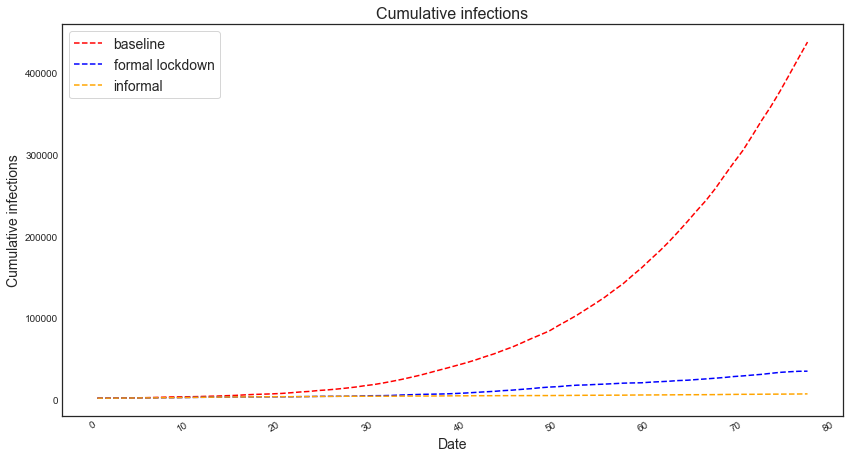

In [14]:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title('Cumulative infections', fontsize='16')

#ax.plot(dates, detected_cases, label='empirical')

ax.plot(data_scenarios[0].index, (data_scenarios[0]['detected'].cumsum() * multiplication_factor), label='baseline', 
        color='red', linestyle='--')

#ax.plot(dates, (data_scenarios[0]['e'] + data_scenarios[0]['i1'] + data_scenarios[0]['i2']) * multiplication_factor, label='baseline')
# ax.plot(dates, (data_scenarios[0]['detected'].cumsum() * multiplication_factor), label='baseline', 
#         color='red', linestyle='--')

#ax.plot(dates, (data_scenarios[1]['e'] + data_scenarios[1]['i1'] + data_scenarios[1]['i2']) * multiplication_factor, label='formal')
ax.plot(data_scenarios[1].index, (data_scenarios[1]['detected'].cumsum() * multiplication_factor), label='formal lockdown', 
        color='blue', linestyle='--')


#ax.plot(dates, (data_scenarios[2]['e']  + data_scenarios[2]['i1'] + data_scenarios[2]['i2']) * multiplication_factor, label='informal')
ax.plot(data_scenarios[2].index, (data_scenarios[2]['detected'].cumsum() * multiplication_factor), label='informal', 
        color='orange', linestyle='--')

#ax.plot(dates, detected_cases)

# myFmt = DateFormatter("%d-%m-%y")
# ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()


ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cumulative infections', fontsize='14')
ax.set_xlabel('Date', fontsize='14')

In [17]:
environments[1] = runner(environments[1], 0, data_folder=data_folder, data_output=environments[1].parameters['data_output'])

1375


In [19]:
if environments[1].parameters['data_output'] == 'csv_light':
    pd.DataFrame(environments[1].infection_quantities).to_csv('{}seed{}/quantities_state_time_0.csv'.format(data_folder,
                                                                                                      seed))

In [20]:
data_formal = pd.read_csv('{}seed{}/quantities_state_time_0.csv'.format(data_folder, seed), index_col=0)

In [21]:
environments[2] = runner(environments[2], 0, data_folder=data_folder, data_output=environments[2].parameters['data_output'])

1396


In [22]:
if environments[2].parameters['data_output'] == 'csv_light':
    pd.DataFrame(environments[2].infection_quantities).to_csv('{}seed{}/quantities_state_time.csv'.format(data_folder,
                                                                                                      seed))

In [23]:
data_informal = pd.read_csv('{}seed{}/quantities_state_time.csv'.format(data_folder, seed), index_col=0)

Text(0.5, 0, 'Days')

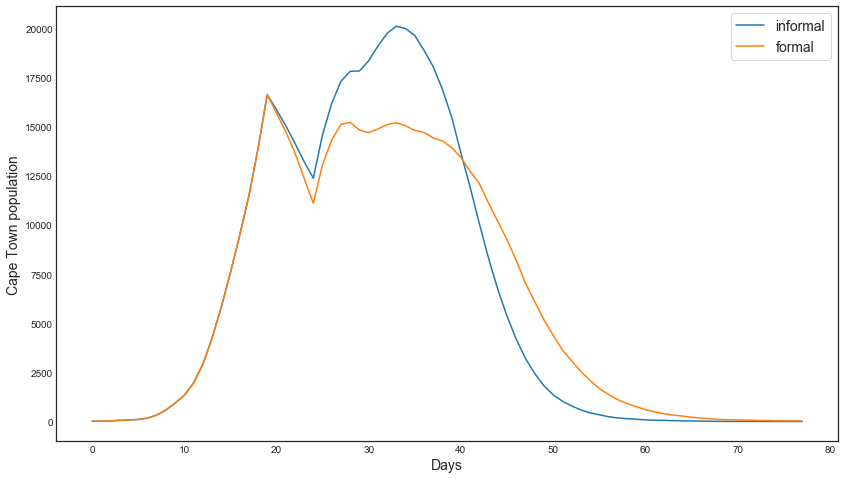

In [25]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(data_informal.index, data_informal['e'], label='informal')
ax.plot(data_formal.index, data_formal['e'], label='formal')

ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

### 2 initialization from pickle

In [46]:
data = open('seed_22_forjoeri.pkl', "rb")
list_of_objects = pickle.load(data)
environment = list_of_objects[0]

In [47]:
# correct time
environment.parameters['time'] = parameters['time']

# correct informality
if parameters["informality_dummy"] == 1.0:
    print('informal = True')
    for agent in environment.agents:
        agent.informality = what_informality(agent.district, neighbourhood_data) * parameters["informality_dummy"]

environment.parameters['probability_transmission']= parameters['probability_transmission']#!!!!###!!!###
environment.parameters['number_of_agents'] = 100000 #!!!!###!!!###
environment.parameters['data_output']=parameters['data_output']#!!!!###!!!###
environment.parameters["total_initial_infections"]=parameters["total_initial_infections"]
environment.parameters['informality_dummy']=parameters["informality_dummy"] 
environment.parameters["lockdown_days"]  = parameters["lockdown_days"] 
environment.parameters["health_system_capacity"] =parameters["health_system_capacity"]

informal = True


### NEW 

In [48]:
# ADD NEW PARAMETER
environment.parameters["perc_infections_detects"] = 1.0#parameters['perc_infections_detects']
# ADD NEWLY DETECTED CASES
environment.newly_detected_cases = [0 for x in range(parameters['time'])]

In [49]:
data_folder = 'measurement/baseline_100k/'
seed = 22

# Simulate model

In [50]:
environment = runner(environment, 0, data_folder=data_folder, data_output=environment.parameters['data_output'])

1396


In [51]:
if parameters["data_output"] == 'csv_light':
    pd.DataFrame(environment.infection_quantities).to_csv('{}seed{}/quantities_state_time.csv'.format(data_folder,
                                                                                                      seed))

# Analyse

In [52]:
data_formal = pd.read_csv('{}seed{}/quantities_state_time_0.csv'.format(data_folder, seed), index_col=0)

In [53]:
data_informal = pd.read_csv('{}seed{}/quantities_state_time.csv'.format(data_folder, seed), index_col=0)

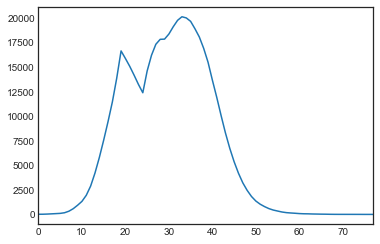

In [54]:
data_informal['e'].plot()
#data_informal['d'].plot()

Text(0.5, 0, 'Days')

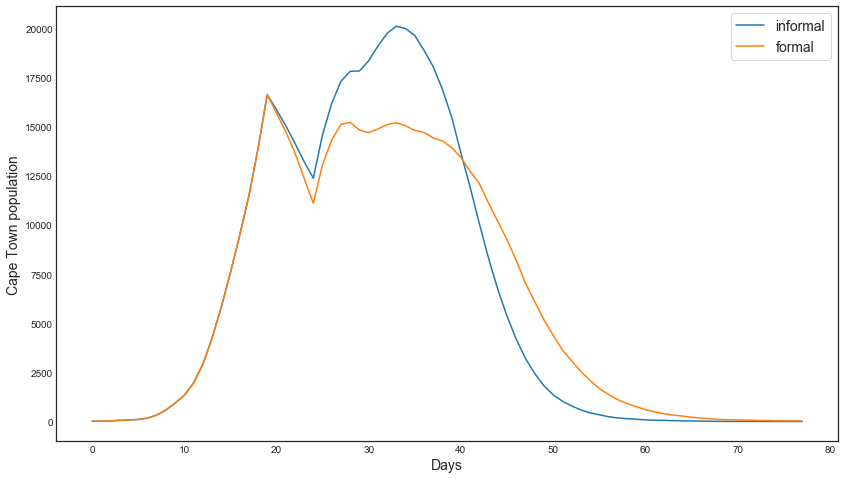

In [55]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(data_informal.index, data_informal['e'], label='informal')
ax.plot(data_formal.index, data_formal['e'], label='formal')

ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

Text(0.5, 0, 'Days')

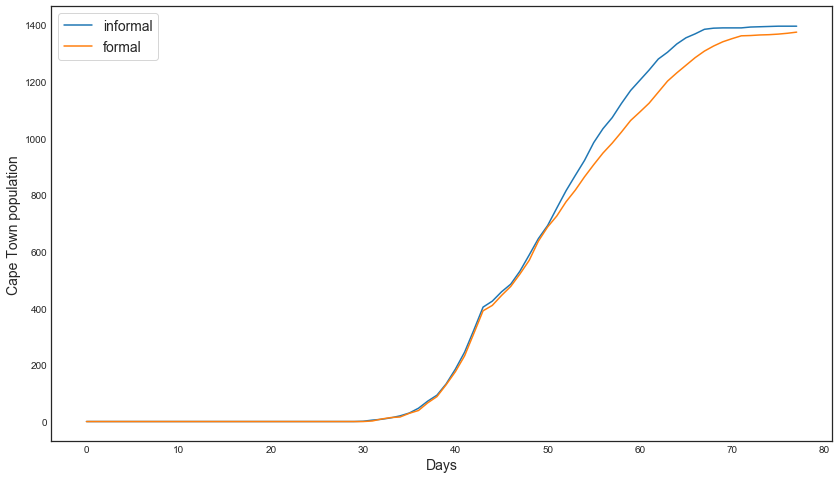

In [56]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(data_informal.index, data_informal['d'], label='informal')
ax.plot(data_formal.index, data_formal['d'], label='formal')

ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')